In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
%matplotlib inline

In [2]:
df = pd.read_csv("dataset/test.csv",delimiter=',')
# df_train = pd.read_csv("dataset/train.csv",delimiter=',')

- TRIP_ID: (String) It contains an unique identifier for each trip;
- TAXI_ID: (integer): It contains an unique identifier for the taxi driver that performed each trip;

- CALL_TYPE: (char) It identifies the way used to demand this service. It may contain one of three possible values:
    - ‘A’ if this trip was dispatched from the central;
    - ‘B’ if this trip was demanded directly to a taxi driver on a specific stand;
    - ‘C’ otherwise (i.e. a trip demanded on a random street).


In [25]:
pd.Categorical.describe(df_train['CALL_TYPE'])

,counts,freqs
categories,,
B,817881,0.478106
C,528019,0.308662
A,364770,0.213232


- ORIGIN_CALL: (integer) It contains an unique identifier for each phone number which was used to demand, at least, one service.
    - It identifies the trip’s customer if CALL_TYPE=’A’.
    - Otherwise, it assumes a NULL value;

In [26]:
pd.Categorical.describe(df_train["ORIGIN_CALL"].fillna(0))

,counts,freqs
categories,,
0.0,1345900,7.867678e-01
2002.0,57571,3.365407e-02
63882.0,6406,3.744732e-03
2001.0,2499,1.460831e-03
13168.0,1314,7.681201e-04
...,...,...
49856.0,1,5.845663e-07
36489.0,1,5.845663e-07
19072.0,1,5.845663e-07


- ORIGIN_STAND: (integer): It contains an unique identifier for the taxi stand. It identifies the starting point of the trip if CALL_TYPE=’B’. Otherwise, it assumes a NULL value;


- DAYTYPE: (char) It identifies the daytype of the trip’s start. It assumes one of three possible values:
    - ‘B’ if this trip started on a holiday or any other special day (i.e. extending holidays, floating holidays, etc.);
    - ‘C’ if the trip started on a day before a type-B day;
    - ‘A’ otherwise (i.e. a normal day, workday or weekend).

The following cell indicates that only "DAY_TYPE" is a useless feature

In [28]:
df_train["DAY_TYPE"].describe()

count     1710670
unique          1
top             A
freq      1710670
Name: DAY_TYPE, dtype: object

- MISSING_DATA: (Boolean) It is FALSE when the GPS data stream is complete and TRUE whenever one (or more) locations are missing

The data with

In [29]:
pd.Categorical.describe(df_train["MISSING_DATA"])
df_train[df_train['MISSING_DATA']==True]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
105621,1374554455620000625,B,NaN,23.0,20000625,1374554455,A,True,"[[-8.612559,41.145975],[-8.612577,41.145975],[..."
171397,1375863510620000454,B,NaN,62.0,20000454,1375863510,A,True,"[[-0.205893,41.010282]]"
299137,1378544246620000057,B,NaN,55.0,20000057,1378544246,A,True,"[[-8.569719,41.166135],[-8.567928,41.166477],[..."
457486,1381233613620000387,C,NaN,NaN,20000387,1381233613,A,True,"[[-8.626347,41.153436],[-8.626275,41.152905],[..."
738466,1386346894620000904,C,NaN,NaN,20000904,1386346894,A,True,"[[-8.652816,40.636575],[-8.652807,40.636566],[..."
782321,1387137779620000640,C,NaN,NaN,20000640,1387137779,A,True,"[[-8.604558,41.161941],[-8.604477,41.162013],[..."
848552,1388351478620000678,A,9738.0,NaN,20000678,1388351478,A,True,"[[-8.609697,41.160276],[-8.609571,41.16033],[-..."
932391,1390005983620000640,C,NaN,NaN,20000640,1390005983,A,True,"[[-8.604792,41.16123],[-8.604801,41.161167],[-..."
1275934,1396631707620000163,C,NaN,NaN,20000163,1396631707,A,True,"[[-10.634022,43.834248]]"
1432196,1399405185620000508,C,NaN,NaN,20000508,1399405185,A,True,"[[-8.620011,41.14683],[-8.619957,41.146659],[-..."


- TIMESTAMP: (integer) Unix Timestamp (in seconds). It identifies the trip’s start;

In [30]:
import datetime
times = df_train["TIMESTAMP"]
x = [datetime.datetime.fromtimestamp(time, datetime.timezone.utc) for time in times]
y = pd.DataFrame(np.array([(t.year,t.month,t.weekday()) for t in x],dtype=int),columns=['year','month','weekday'],dtype='object')
pd.Categorical.describe(y['weekday'])

,counts,freqs
categories,,
4,277313,0.162108
5,258636,0.151190
3,247025,0.144402
1,234734,0.137218
2,232617,0.135980
6,230397,0.134682
0,229948,0.134420


POLYLINE: (String): It contains a list of GPS coordinates (i.e. WGS84 format) mapped as a string. The beginning and the end of the string are identified with brackets (i.e. [ and ], respectively). Each pair of coordinates is also identified by the same brackets as [LONGITUDE, LATITUDE]. This list contains one pair of coordinates for each 15 seconds of trip. The last list item corresponds to the trip’s destination while the first one represents its start;

In [10]:
def str2trajectory(df,n=-1,return_mask=False):
    series = []
    mask = []
    if n>=0:
        df_new = df.sample(n)
        for flag,j in zip(df_new["MISSING_DATA"],df_new["POLYLINE"]):
            try:
                assert not flag
                series.append(np.array(j.replace('[','').replace(']','').split(','),float))
            except:
                pass
    else:
        for flag,j in zip(df["MISSING_DATA"],df["POLYLINE"]):
            try:
                assert flag==False
                series.append(np.array(j.replace('[','').replace(']','').split(','),float))
                mask.append(True)
            except:
                mask.append(False)
    if return_mask and n<0:
        return series,np.array(mask)
    else:
        return series

##### Geohash

In [3]:
import numpy as np
_base32 = np.array(list('0123456789bcdefghjkmnpqrstuvwxyz'))
class GeoHash:
    def __init__(self):
        pass

    @staticmethod
    def _encode(lat, lon, mid_lat, mid_lon, pre, p,hashn):
        if pre==-1:
            return
        hash_level_lat = 1 << (2 * pre)
        hash_level_lon = 1 << (2 * pre+1)
        mask_lat = lat > mid_lat
        mask_lon = lon > mid_lon
        hashn += hash_level_lat * mask_lat + hash_level_lon * mask_lon
        mid_lat = mid_lat + (mask_lat * 2 - 1) * (180/(1<<p))
        mid_lon = mid_lon + (mask_lon * 2 - 1) * (360/(1<<p))

        GeoHash._encode(lat, lon, mid_lat, mid_lon, pre-1, p+1,hashn)
    @staticmethod
    def _d2c(hashn):
        hashn = hashn.copy()
        str_hash = np.full(hashn.shape[0],'',dtype=object)
        while (hashn>0).any():
            hash1 = list(hashn%32)
            str_hash = _base32[hash1] + str_hash
            hashn = hashn//32
        return str_hash
    @staticmethod
    def encode(se: np.ndarray, pre=12,return_str = False):
        """
        Args:
            se:np.ndarray [lon,lat] mu LATITUDE 纬度, lam LONGITUDE 经度
        Return:
            geohash
        """
        se_lat = se[1::2] + 90
        se_lon = se[::2] + 180

        hashn = np.zeros(se.shape[0]//2,dtype=np.int64)
        mid_lat = np.full(se.shape[0]//2,90)
        mid_lon = np.full(se.shape[0]//2,180)
        GeoHash._encode(se_lat,se_lon,mid_lat,mid_lon,pre*5//2-1,2,hashn)
        if return_str:
            return hashn,GeoHash._d2c(hashn)
        else:
            return hashn
    @staticmethod
    def _decode(lon,lat,seq,p,pre):
        if pre==-1:
            return
        lat_mask = (1<<(2*pre) & seq > 0)*2-1
        lon_mask = (1<<(2*pre+1) & seq > 0)*2-1
        lon += lon_mask*(180/(1<<p))
        lat += lat_mask*(90/(1<<p))
        GeoHash._decode(lon,lat,seq,p+1,pre-1)

    @staticmethod
    def decode(seq,pre=12):
        """
        Args:
            seq: (N,) encode
        """
        lon = np.full(seq.shape[0],180.)
        lat = np.full(seq.shape[0],90.)
        GeoHash._decode(lon,lat,seq,1,pre*5//2-1)
        lon -= 180
        lat -= 90
        return np.stack([lon,lat],1).reshape(-1)

#### Using GeoHash to cluster

In [4]:
GEOHASHLEVEL = 7
class LonLatVocal:
    def __init__(self):
        self._wordMin = 0
        self._wordMax = 0
    def __len__(self):
        return self._wordMax
    def fit(self,df,n=100000,quantile=[0.01,0.99],verbose=False):
        series = str2trajectory(df,n)
        se = np.concatenate(series)
        lat = se[1::2]
        lon = se[::2]
        def getQmask(x):
            return np.logical_and(x<=np.quantile(x,quantile[1]),x>=np.quantile(x,quantile[0]))
        mask = np.logical_and(getQmask(lat),getQmask(lon))
        se_mask = np.stack([lon[mask],lat[mask]],1).reshape(-1)
        x = GeoHash.encode(se_mask,GEOHASHLEVEL)
        if verbose:
            print(f"Origin size {len(se):d}, [{quantile[0]},{quantile[1]}] {len(se_mask):d}",)
        self._wordMin = x.min()
        x_short = x-self._wordMin
        if verbose:
            print(f"reserved class size {max(x_short)}")
        self._wordMax = x_short.max()
    def transform(self,series,arrival=False,return_mask=False,test=False):
        series_trans = []
        mask = []
        for se in series:
            x = GeoHash.encode(se,GEOHASHLEVEL)
            x = x-self._wordMin
            if test:
                x[np.logical_or(x > self._wordMax,x < 0)] = -1 # padding
                series_trans.append(x[-1] if arrival else x)
                mask.append(True)
                continue
            if (x <= self._wordMax).all() and (x >= 0).all():
                if arrival or len(x) > 1:
                    series_trans.append(x[-1] if arrival else x)
                    mask.append(True)
                else:
                    mask.append(False)
            else:
                mask.append(False)
        if return_mask:
            return series_trans,np.array(mask)
        else:
            return series_trans
    def decode(self,trans_se,using_list=True):
        """
        Args:
            trans_se: (N,M) or (N,)
        """
        assert not using_list and trans_se.ndim==1
        if using_list:
            decode_se = []
            for se in trans_se:
                se += self._wordMin
                decode_se.append(GeoHash.decode(se,GEOHASHLEVEL))
        else:
            decode_se = GeoHash.decode(trans_se+self._wordMin,GEOHASHLEVEL)
        return decode_se


In [29]:
import pickle as pkl
model = LonLatVocal()
model.fit(df_train[:100000],n=-1,verbose=True)
with open("geohashmodel.pt",'wb') as f:
    pkl.dump(model,f)

Origin size 9550022, [0.01,0.99] 9264260
reserved class size 56959


Get the geohash of the arrival

In [5]:
import pickle as pkl
with open("geohashmodel.pt",'rb') as f:
    model = pkl.load(f)

In [26]:
sample_df = df_train.sample(100000)
series,mask = str2trajectory(sample_df,return_mask=True)
sample_df = sample_df[mask]
whole_seq,mask = model.transform(series,return_mask=True)

arrival = np.array([seq[-1] for seq in whole_seq])
starter = np.array([seq[0] for seq in whole_seq])
train_seq = np.array([seq[:-1] for seq in whole_seq])
train_lonlat_seq = []
for m,seq in zip(mask,series):
    if m:
        train_lonlat_seq.append((seq[-1],seq[-2]))
train_lonlat_seq = train_lonlat_seq
sample_df = sample_df[mask]
sample_df["arr"] = train_lonlat_seq
sample_df["arrival"] = arrival
sample_df["starter"] = starter
sample_df["seq"] = train_seq
# sample_df.to_csv("sample_data.csv")

In [9]:
# read csv sample data
sample_df = pd.read_csv("sample_data.csv")

how to decode

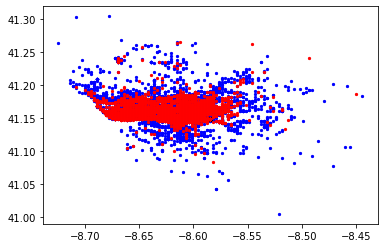

In [17]:
arrival = sample_df["arrival"].to_numpy()
decode_loc = model.decode(arrival,using_list=False)
plt.scatter(decode_loc[::2],decode_loc[1::2],s=5,c='b')
starter = sample_df["starter"].to_numpy()
decode_loc = model.decode(starter,using_list=False)
plt.scatter(decode_loc[::2],decode_loc[1::2],s=5,c='r')

reserved testdataset points rate 94.805%


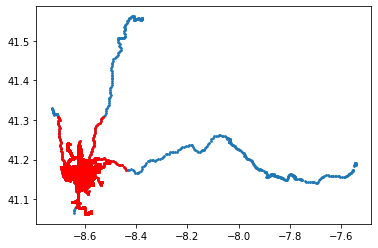

In [16]:
series = str2trajectory(df)
se = np.concatenate(series)
plt.scatter(se[::2],se[1::2],s=3)
x = GeoHash.encode(se,GEOHASHLEVEL)
mask = np.logical_and((x - model._wordMin)<=model._wordMax,(x - model._wordMin)>=0)
print(f"reserved testdataset points rate {np.sum(mask)/len(x)*100:.3f}%")
plt.scatter(se[::2][mask],se[1::2][mask],s=3,c='r')

longitude and latitude to xy coordination

[source](https://blog.csdn.net/EagleLY5894/article/details/104118465)

In [6]:
class LatLonTransform:
    def __init__(self,se_latlon):
        e = 0.0818191908426
        a = 6378137.0/1000
        mu = se_latlon[:,0]
        lam = se_latlon[:,1]
        mu = np.deg2rad(mu)
        lam = np.deg2rad(lam)
        self.mu_0 = np.min(mu)
        self.lam_0 = np.min(lam)
        self.Rn = a*(1-e**2)/(1-e**2*np.sin(self.mu_0)**2)**(3/2)
        self.Re = a/(1-e**2*np.sin(self.mu_0)**2)**(1/2)
    def transform(self,se_latlon):
        """
        se_latlon [N,2]
        mu LATITUDE 纬度, lam LONGITUDE 经度
        """
        mu = se_latlon[:,0]
        lam = se_latlon[:,1]
        mu = np.deg2rad(mu)
        lam = np.deg2rad(lam)

        x = np.cos(self.mu_0)*self.Re*(lam-self.lam_0)
        y = self.Rn*(mu-self.mu_0)

        return np.stack([x,y],1)
    def detransform(self,se_xy):
        x = se_xy[:,0]
        y = se_xy[:,1]
        lat = y/self.Rn+self.mu_0
        lon = x/self.Re/np.cos(self.mu_0)+self.lam_0
        lat = np.rad2deg(lat)
        lon = np.rad2deg(lon)
        return np.stack([lat,lon],1)

In [9]:
series = str2trajectory(sample_df,-1)
se = np.concatenate(series)
se_mu = se[1::2]
se_lam = se[::2]
se_mulam = np.stack([se_mu,se_lam],1)
trans = LatLonTransform(se_mulam)

error on the test dataset

In [9]:
with open('trans.pt','wb') as f:
    pkl.dump(trans,f)

NameError: name 'trans' is not defined

error of this method is 0.00677153 km


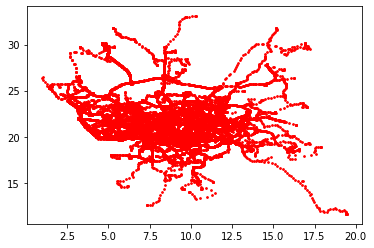

In [12]:
with open("trans.pt",'rb') as f:
    trans = pkl.load(f)
series = str2trajectory(sample_df,-1)
se = np.concatenate(series)
se_mu = se[1::2]
se_lam = se[::2]
se_mulam = np.stack([se_mu,se_lam],1)
se_xy = trans.transform(se_mulam)
# se_xy_n = (se_xy.astype(float)-se_xy.min(0,keepdims=True))/(se_xy.max(0,keepdims=True)-se_xy.min(0,keepdims=True))
plt.scatter(se_xy[:,0],se_xy[:,1],s=3, c="red")
from geopy.distance import geodesic
err = 0
n=1000
for i in range(n):
    n1,n2 = 0,0
    while n1 == n2:
        n1,n2 = np.random.randint(0,len(se_mulam),(2,))
    err += abs((geodesic(se_mulam[n1],se_mulam[n2]).km - np.linalg.norm(se_xy[n1]-se_xy[n2])))
print(f"error of this method is {err/n:.8f} km")

Using tfidf to compute the weight of which location in the trajectory

In [16]:
from gensim.models.tfidfmodel import TfidfModel
import pickle as pkl
import re
try:
    texts = list(map(lambda x:list(map(lambda y:int(y),re.findall(r"\d+",x))),sample_df["seq"]))
except:
    texts = sample_df['seq']
corpus = [np.stack(np.unique(np.array(doc),return_counts=True),1).tolist() for doc in texts]

tf_idf_model = TfidfModel(corpus)

texts = sample_df['seq']
def assignTFIDF(seq):
    weight = np.array([tf_idf_model.dfs[s] for s in seq])
    weight = weight/weight.sum()
    return weight

weights = [assignTFIDF(sen) for sen in texts]

trajectory embedding using the same idea as deepwalk

In [9]:
import torch
import torch.nn as nn
device = 'cuda:0'
class skipgram(nn.Module):
    def __init__(self, N, D):
        super(skipgram, self).__init__()
        self.D = D
        self.embed = nn.Embedding(N+1, D) # including padding
    def forward(self,x):
        return self.embed(x)
ckpt = torch.load("result_15.pt",device)
model_skip = skipgram(len(model)+1,32).to(device)
model_skip.load_state_dict(ckpt)
model_skip.eval()

skipgram(
  (embed): Embedding(56961, 32)
)

get each embedding vector in train dataset,with tfidf weighting

In [10]:
X = []
for s in sample_df['seq']:
    s = torch.LongTensor(s+1).to(device)
    embed = model_skip(s).detach().cpu().numpy() # T,D
    X.append(np.mean(embed,axis = 0))

In [28]:
# X = np.array(X) # N,D
X = sample_df['seq'].to_list()
y = np.array(sample_df['arr'].to_list())
with open('trans.pt','rb') as f:
    trans = pkl.load(f)
y = trans.transform(y)

In [29]:
import pickle as pkl
with open("train_data.pth",'wb') as f:
    pkl.dump([X,y],f)

In [19]:
import pickle as pkl
import numpy as np
# with open("train_data.pth",'rb') as f:
#     X,y = pkl.load(f)
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
model_reg = MultiOutputRegressor(SVR(verbose=1))
model_reg.fit(X,y)

[LibSVM][LibSVM]

MultiOutputRegressor(estimator=SVR(verbose=1))

In [20]:
with open("svc.pt",'wb') as f:
    pkl.dump(model_reg,f)

In [21]:
with open("svc.pt",'rb') as f:
    model_reg = pkl.load(f)

In [22]:
from geopy.distance import geodesic
import pickle as pkl

from sklearn.metrics import mean_squared_error

pred = trans.detransform(model_reg.predict(X)) # lat,lon
y = trans.detransform(y)
dist = 0.
for i,(lat,lon) in enumerate(pred):
    dist += geodesic([lat,lon],y[i]).km
dist/len(pred)

2.321086529915166

In [17]:
HIDDEN_SIZE=256
import torch
import torch.nn as nn
import torch.nn.functional as F
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.fc1 = nn.Linear(32,HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE,2)
    def forward(self,x):
        l2 = F.relu(self.fc1(x))
        return self.fc2(l2)
model_mlp = mlp()
model_mlp.load_state_dict(torch.load("WORDCNN/model_best.pt","cpu"))

<All keys matched successfully>

test

In [62]:
se,mask = str2trajectory(df,return_mask=True)
seq,mask_seq = model.transform(se,arrival=False,return_mask=True,test=True)

########## tfidf #################
# from gensim.models.tfidfmodel import TfidfModel
# import pickle as pkl
# import re
#
# corpus = [np.stack(np.unique(np.array(doc),return_counts=True),1).tolist() for doc in seq]
#
# tf_idf_model = TfidfModel(corpus)
#
# texts = sample_df['seq']
# def assignTFIDF(seq):
#     weight = np.array([tf_idf_model.dfs[s] for s in seq])
#     weight = weight/weight.sum()
#     return weight
#
# weights = [assignTFIDF(sen) for sen in seq]
############# to vector #############
X = []
# for weight,s in zip(weights,seq):
#     s = torch.LongTensor(s+1).to(device)
#     embed = model_skip(s).detach().cpu().numpy() # T,D
#     X.append(np.sum(weight.reshape(-1,1)*embed,axis = 0))
# for s in seq:
#     s = torch.LongTensor(s+1).to(device)
#     embed = model_skip(s).detach().cpu().numpy() # T,D
#     X.append(np.mean(embed,axis = 0))
# X = np.array(X) # N,D
X = seq

[array([-8.585676, 41.148522, -8.585712, 41.148639, -8.585685, 41.148855,
       -8.58573 , 41.148927, -8.585982, 41.148963, -8.586396, 41.148954,
       -8.586072, 41.14872 , -8.586324, 41.147847, -8.586999, 41.14746 ,
       -8.586576, 41.147154, -8.584884, 41.146623]), array([-8.610876, 41.14557 , -8.610858, 41.145579, -8.610903, 41.145768,
       -8.610444, 41.146191, -8.609445, 41.146758, -8.608896, 41.147118,
       -8.608968, 41.147127, -8.608707, 41.147532, -8.608347, 41.148117,
       -8.608149, 41.148351, -8.608041, 41.148576, -8.607654, 41.14926 ,
       -8.607348, 41.149899, -8.607393, 41.149899, -8.607357, 41.149962,
       -8.606817, 41.150979, -8.606358, 41.151915, -8.605719, 41.152788,
       -8.604981, 41.153319, -8.604783, 41.154345, -8.604828, 41.154372,
       -8.604801, 41.155353, -8.604648, 41.156775, -8.604522, 41.158197,
       -8.604513, 41.159943, -8.604378, 41.160555, -8.604378, 41.1606  ,
       -8.604369, 41.160645, -8.60436 , 41.160807, -8.604162, 41.16117

TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable deg2rad method

In [21]:
# for path
# pred = model_mlp(torch.FloatTensor(X)).detach().cpu().numpy()

In [23]:
pred = trans.detransform(pred)
lat = pred[:,0]
lon = pred[:,1]

In [74]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
device = "cuda:0"
HIDDEN_SIZE=256
class mlp(nn.Module):
    def __init__(self,vocal_max):
        super(mlp, self).__init__()
        self.embed = nn.Embedding(vocal_max+1,32,padding_idx=0) # padding
        self.conv = nn.Conv1d(32,32,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(32,HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE,2)
        self.dropout = nn.Dropout(0.5)
    def forward(self,x):
        embedding = self.embed(x) # B,T,32
        embedding = embedding.permute(0,2,1) # B,C,T
        l1 = F.relu(self.conv(embedding))
        l1_max = torch.max(l1,dim=-1)[0] # B,32 over-time-maxpooling
        l2 = self.dropout(F.relu(self.fc1(l1_max)))
        return self.fc2(l2)
model_em = mlp(len(model)+1).to(device).eval()
model_em.load_state_dict(torch.load("WORDCNN/model_best.pt",device))
pred = []
for s,true_se in zip(X,se):
    x = torch.LongTensor(s+1).view(1,-1).to(device)
    y = model_em(x).detach().cpu().numpy().reshape(-1)
    if True:
        pred.append(trans.transform(np.stack([true_se[1::2],true_se[::2]],1))[-1])
        continue
    pred.append(y)

In [75]:
pred = np.stack(pred,0)
with open('trans.pt','rb') as f:
    trans = pkl.load(f)
pred = trans.detransform(pred)
lat = pred[:,0]
lon = pred[:,1]

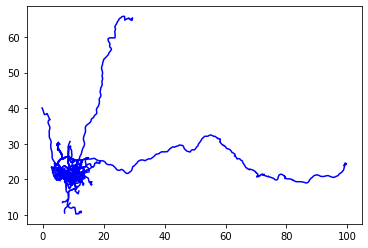

In [76]:
for i,(x,y) in enumerate(zip(se,trans.transform(pred))):
    x = trans.transform(np.stack([x[1::2],x[::2]],1))
    # plt.plot(np.concatenate([x[:,0],y[0].reshape((1,))],axis=0),np.concatenate([x[:,1],y[1].reshape((1,))],axis=0),'b-')
    plt.plot(x[:,0],x[:,1],'b-')
    plt.plot([x[-1,0],y[0]],[x[-1,1],y[1]],'r-')

In [77]:
tra = df["TRIP_ID"]

sub_df = pd.DataFrame(data=list(zip(tra,lat,lon)),columns=["TRIP_ID","LATITUDE","LONGITUDE"])
sub_df.to_csv("mysubmit.csv",index=False)
!kaggle competitions submit -c pkdd-15-predict-taxi-service-trajectory-i -f submission.csv -m "Message"


'kaggle' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
